# Thresholded Networks
Here we compare the clustering when we ignore synapses with low confidence

In [25]:
import os
import time
import pandas as pd
import numpy as np
import networkx as nx
import dotmotif
import collections
from scipy import sparse as sp
from scipy.stats import rankdata

from itertools import combinations, combinations_with_replacement, cycle
from functools import reduce

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["font.sans-serif"] = "Helvetica"

import bokeh
from bokeh.io import output_notebook, output_file, show, save
from bokeh.plotting import figure
from bokeh.models import (Rect, MultiLine, Circle, Span, Label,
                          GraphRenderer, StaticLayoutProvider,
                          NodesAndLinkedEdges,
                          HoverTool, TapTool, ColumnDataSource,
                          LinearColorMapper, LogColorMapper, CategoricalColorMapper,
                          CategoricalMarkerMapper,
                          BoxSelectTool,
                          ColorBar, BasicTicker, BoxZoomTool, FactorRange,
                          Range1d)
from bokeh.models import CategoricalTicker, FixedTicker, BoxAnnotation
from bokeh.models import Arrow, NormalHead, OpenHead, VeeHead, LabelSet

from bokeh.transform import transform, factor_cmap, linear_cmap, log_cmap
from bokeh.layouts import row, column, gridplot
output_notebook()

import ipyvolume as ipv

import colorcet as cc


from visualization.vis import *
from visualization.vis3d import *
# from visualization.vis import (draw_graph,
#                                circle_layout_graph, breakdown_flowchart_graph,
#                                breakdown_barchart_figure, code_heatmap,
#                                display_dataframe, roi_adj_fig,
#                                tuple_to_string, repeat_to_match_lengths,
#                                poincare_geodesic, outer_loop_circle,
#                                normalize)
from visualization.reduce_graphs import reduced_graph, cluster_codes, subgraph
# from util import log_msg, simplify_type
from util import *

from math import pi

log_msg("Imports complete")

Loading BokehJS ...

2022 11 12 08:51:08  Imports complete


In [2]:
hemibrain_version = "v1.1"
log_msg("Hemibrain data set being used:", hemibrain_version)

2022 11 12 08:41:42  Hemibrain data set being used: v1.1


In [3]:
from neuprint import Client
from neuprint import fetch_roi_hierarchy


auth_token_file = open("flybrain.auth", 'r')
auth_token = next(auth_token_file).strip()
np_client = Client('neuprint.janelia.org', dataset='hemibrain:' + hemibrain_version, token=auth_token)

log_msg("neuprint Client set up as `np_Client`, version", np_client.fetch_version())

2022 11 12 08:41:47  neuprint Client set up as `np_Client`, version 0.1.0


## Visualization Helper Code

In [4]:
preproc_dir = "hemibrain/preprocessed-" + hemibrain_version
preproc_nodes = "preprocessed_nodes.csv"
preproc_centroids = "preprocessed_nodes_with_centroids.csv"
preproc_edges = "preprocessed_undirected_edges.csv"

hemibrain_dir = "hemibrain/exported-traced-adjacencies-" + hemibrain_version
hemibrain_nodes = "traced-neurons.csv"
hemibrain_edges = "traced-total-connections.csv"
hemibrain_roi_edges = "traced-roi-connections.csv"

figure_dir = os.path.join("figures","paper")
movie_dir = os.path.join("movies")
analysis_dir = os.path.join("analysis",hemibrain_version)
obj_dir = os.path.join("obj",hemibrain_version)  # 3d objects from, e.g. fetch_roi_mesh
skel_dir = os.path.join("skeleton", hemibrain_version)  # skeleta of neurons in .csv format


for d in [figure_dir, analysis_dir, obj_dir, movie_dir]:
    if not os.path.isdir(d):
        log_msg("Creating directory", d)
        os.makedirs(d)

reneel_params = list(sorted(['0.0', '1.0', '0.5', '0.25', '0.1', '0.05', '0.75'], key=float))
confidence_thresholds = ['0.0', '0.6', '0.8']
type_params = ['celltype','instance']
list_of_params = reneel_params + type_params

log_msg("Set up directory info and useful lists")

2022 11 12 08:41:47  Set up directory info and useful lists


In [5]:
palette = cc.glasbey_dark + cc.glasbey + cc.glasbey_light

In [6]:
def color_mapper(val, colors=palette, override={}):
    return override.get(val, palette[val % len(palette)])

In [7]:
def fig_out(file=None, title=None):
    if file is None:
        file = 'temp.html'
    if not file.endswith('.html'):
        file = file + '.html'
    if title is None:
        title = file.replace('.html', '').replace('_',' ')
    return {'filename': os.path.join(figure_dir, file), 'title': title}

In [8]:
arrow_coords = [dict(x_start=20, x_end=70, y_start=45, y_end=45, start_units='screen', end_units='screen'),
                dict(x_start=45, x_end=45, y_start=20, y_end=70, start_units='screen', end_units='screen')]
arrow_labels = {'x': {'start': 'L', 'end': 'M'},
                'y': {'start': 'P', 'end': 'A'},
                'z': {'start': 'V', 'end': 'D'}}
# example usage:
#     f.add_layout(Arrow(start=NormalHead(size=5), end=NormalHead(size=5), **arrow_coords[0]))
#     f.add_layout(Arrow(start=NormalHead(size=5), end=NormalHead(size=5), **arrow_coords[1]))
#     for s in ['start', 'end']:
#         for ax in [0,1]:
#             f.add_layout(Label(x=arrow_coords[ax]['x_'+s], y=arrow_coords[ax]['y_'+s], x_units='screen', y_units='screen', text=arrow_labels[xy[ax]][s]))

In [9]:
# Functions for handling 3d visualization
def get_roi_mesh(roi, client=np_client, encoding='utf-8'):
    """Try to load the given mesh .obj file; if it doesn't exist, download
    the mesh using `client.fetch_roi_mesh`"""
    if os.path.isfile(os.path.join(obj_dir, roi + '.obj')):
        log_msg("Loading mesh for", roi, "from file")
        return roi_mesh_from_file(roi + '.obj')
    else:
        log_msg("Fetching mesh for", roi, "from client")
        b = client.fetch_roi_mesh(roi, os.path.join(obj_dir, roi + '.obj'))
        return parse_mesh_bytes(b, encoding)

def roi_mesh_from_file(file):
    """Load the .obj file (file does not end with '.obj', that will be appended)
    and return (X, Y, Z, T) where X,Y,Z are 1-d arrays of coordinates and T is a
    list of lists of three indices"""
    if not file.endswith('.obj'):
        file = file + '.obj'
    mesh_file = open(os.path.join(obj_dir, file), 'r')
    vertices = get_vertices(mesh_file.readlines())
    mesh_file.seek(0)
    triangles = get_triangles(mesh_file.readlines())
    return vertices[0], vertices[1], vertices[2], triangles

def parse_mesh_bytes(b, encoding='utf-8'):
    """Given bytes (e.g. as returned by fetch_roi_mesh), parse into vertices and
    triangles. Returns (X,Y,Z,T) as in get_roi_mesh_from_file"""
    lines = b.decode(encoding).split('\n')
    vertices = get_vertices(lines)
    triangles = get_triangles(lines)
    return vertices[0], vertices[1], vertices[2], triangles
    
def get_vertices(thing):
    return np.array([[float(c) for c in l.split()[1:]] for l in thing if l.startswith('v')]).T
def get_triangles(thing):
    return [[int(c) - 1 for c in l.split()[1:]] for l in thing if l.startswith('f')]

def get_skeleton(bodyId, client=np_client):
    """Try to load the given skeleton csv file; if it doesn't exist, download
    the skeleton using `client.fetch_skeleton` and save it to disk.
    
    To avoid confusion, the 'raw' data will be returned; formatting
    for ipyvolume requires dropping rows with `link == -1` and
    subtracting one from all `rowId` and `link` values.
    
    Example:
    ```
    s = get_skeleton(body)
    skel_lines = s[s.link != -1][['rowId', 'link']].values - 1  # change from 1-based to 0-based indexing
    ipv.plot_trisurf(s['x'], s['y'], s['z'], lines=skel_lines)
    ```
    """
    csv_file = os.path.join(skel_dir, str(bodyId) + '.csv')
    if os.path.isfile(csv_file):
        return pd.read_csv(csv_file, index_col=0)
    else:
        s = client.fetch_skeleton(bodyId, format='pandas')
        s.to_csv(csv_file)
        return s
    
def simple_ipv_plots(df, chis=reneel_params, figure={}, view={}):
    """Generate an ipyvolume figure per parameter in `chis` showing the skeletons
    of all neurons in `df` colored by that value of chi."""
    for color_by in chis:
        ipv.figure(**figure)
        ipv.show()
        ipv.style.box_off()
        ipv.style.axes_off()
        for i, (body, cluster) in enumerate(zip(df.index, df[color_by])):
            s = get_skeleton(body)
            skel_lines = s[s.link != -1][['rowId', 'link']].values - 1
            ipv.plot_trisurf(s['x'], -s['z'], s['y'], lines=skel_lines, color=palette[cluster % len(palette)])
        ipv.view(**view)

## Load the node dataframe

In [10]:
log_msg("Loading node dataframe")
if os.path.isfile(os.path.join(preproc_dir, preproc_centroids)):
    log_msg("  (with centroids)")
    HB_node_df = pd.read_csv(os.path.join(preproc_dir, preproc_centroids), index_col=0)
else:
    log_msg("  (without centroids)")
    HB_node_df = pd.read_csv(os.path.join(preproc_dir, preproc_nodes), index_col=0)
HB_node_df = HB_node_df[reneel_params + HB_node_df.columns.to_list()[len(reneel_params):]] #reorganize columns
log_msg("Creating dictionary with confidence-thresholded cluster info")
node_dfs = {
    0.0: HB_node_df[reneel_params],
    0.6: pd.read_excel("hemibrain/confidence_threshold/06confidence.xlsx", skiprows=1, index_col=0),
    0.8: pd.read_excel("hemibrain/confidence_threshold/08confidence.xlsx", skiprows=1, index_col=0)
}
log_msg("Adjusting column names")
node_dfs[0.6].columns = reneel_params
node_dfs[0.8].columns = reneel_params
log_msg("Done!")

log_msg("Creating master_node_df with cluster info across chi and confidence threshold")
master_node_df = node_dfs[0.0].merge(node_dfs[0.6], suffixes=['', '_0.6'], left_index=True, right_index=True)
master_node_df = master_node_df.merge(node_dfs[0.8], suffixes=['', '_0.8'], left_index=True, right_index=True)
# master_node_df
# threshold_06.set_index('ID', inplace=True)
# threshold_06.rename(columns={c: str(c) + '_0.6' for c in threshold_06.columns}, inplace=True)


# threshold_08 = pd.read_excel("hemibrain/confidence_threshold/08confidence.xlsx", skiprows=1).rename(columns={'chi=0':'0.0', 1:'1.0'})
# threshold_08.set_index('ID', inplace=True)
# threshold_08.rename(columns={c: str(c) + '_0.8' for c in threshold_08.columns}, inplace=True)

2022 11 12 08:41:47  Loading node dataframe
2022 11 12 08:41:47    (with centroids)
2022 11 12 08:41:48  Creating dictionary with confidence-thresholded cluster info
2022 11 12 08:41:52  Adjusting column names
2022 11 12 08:41:52  Done!
2022 11 12 08:41:52  Creating master_node_df with cluster info across chi and confidence threshold


In [11]:
def get_cluster_representatives(chi, n=100, cluster_threshold=10, df=HB_node_df, name="default"):
    """Return a subset of `df`, selecting up to `n` cells from each cluster
    found at chi = `chi`, ignoring clusters below `cluster_threshold` cells.
    
    Will first check if such a selection has been saved before. `name` lets
    you save different subsets of the same combination of version/chi/n/threshold"""
    fname = "selected_cells_" + "_".join([hemibrain_version, chi, str(n), str(cluster_threshold), name]) + ".txt"
#     selection_file = os.path.join(figure_dir, "selected_cells_" + hemibrain_version + "_" + chi + "_" + str(n) + "_" + str(cluster_threshold) + "_" +  ".txt")
    selection_file = os.path.join(figure_dir, "bodyids", fname)
    if os.path.isfile(selection_file):
        log_msg("Found previous selection using these criteria.")
        log_msg("To refresh, delete the file", selection_file)
        f = open(selection_file, "r")
        random_set = [int(l) for l in f.readlines()]
        f.close()
    else:
        log_msg("Selecting cluster representatives from provided df")
        vc = df[chi].value_counts()
        vc = vc[vc >= cluster_threshold]
        random_set = []
        for c in vc.index:
            c_df = df[df[chi] == c]
            random_c_set = np.random.choice(c_df.index, replace=False, size=min(n, c_df.shape[0])).astype(int)
            random_set = np.union1d(random_set, random_c_set).astype(int)
        log_msg("Writing to file", selection_file)
        f = open(selection_file, "w")
        for i in random_set:
            print(i, file=f)
        f.close()
    log_msg("Selected", len(random_set), "/", df.shape[0], "(%3.2f%%) of the given dataframe" % (100 * len(random_set) / df.shape[0]))
    return df.loc[random_set]

### Load the directed edge dataframe

In [12]:
log_msg("Loading directed edges from csv")
HB_edge_df = pd.read_csv(os.path.join(hemibrain_dir, hemibrain_edges)).rename(columns={"bodyId_pre": "pre", "bodyId_post":"post"})
log_msg("Creating dictionary with edge dfs")
edge_dfs = {
    0.0: HB_edge_df,
    0.6: pd.read_csv("hemibrain/confidence_threshold/filtered_connections_confidence_0.6.csv",index_col=0),
    0.8: pd.read_csv("hemibrain/confidence_threshold/filtered_connections_confidence_0.8.csv",index_col=0)
}
log_msg("Combining edge dfs")
master_edge_df = HB_edge_df.merge(edge_dfs[0.6].rename(columns={'bodyId_pre':'pre', 'bodyId_post':'post'}),
                                  on=['pre','post'],
                                  suffixes=['_0.0','_0.6'],
                                  how='outer')
master_edge_df['weight_0.6'] = master_edge_df['weight_0.6'].fillna(0).astype(int)
master_edge_df = master_edge_df.merge(edge_dfs[0.8].rename(columns={'bodyId_pre':'pre','bodyId_post':'post'}),
                                      on=['pre','post'],
                                      how='outer').rename(columns={'weight':'weight_0.8'})
master_edge_df['weight_0.8'] = master_edge_df['weight_0.8'].fillna(0).astype(int)

log_msg("Adding pre/post cluster ID across all confidence thresholds, all values of chi")
for c, df in node_dfs.items():
    master_edge_df = master_edge_df.merge(df, left_on='pre', right_index=True).rename(columns={chi: chi + "_pre_"+str(c) for chi in reneel_params})
    master_edge_df = master_edge_df.merge(df, left_on='post', right_index=True).rename(columns={chi: chi+'_post_'+str(c) for chi in reneel_params})
# master_edge_df.merge(node_dfs[0.0], left_on='pre', right_index=True).rename(columns={c: c+'pre0.0'})
master_edge_df
log_msg("Done!")

2022 11 12 08:41:52  Loading directed edges from csv
2022 11 12 08:41:53  Creating dictionary with edge dfs


/Users/sekunder/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


2022 11 12 08:41:54  Combining edge dfs
2022 11 12 08:41:58  Adding pre/post cluster ID across all confidence thresholds, all values of chi
2022 11 12 08:42:09  Done!


In [13]:
# log_msg("Loading directed edges from csv")
# HB_edge_df = pd.read_csv(os.path.join(hemibrain_dir, hemibrain_edges)).rename(columns={"bodyId_pre": "pre", "bodyId_post":"post"})
# log_msg("Done!")

In [14]:
# log_msg("Merging in cell info to edge df")
# HB_edge_df = HB_edge_df.merge(HB_node_df[list_of_params + ['type_group']], left_on='pre', right_index=True)
# HB_edge_df = HB_edge_df.merge(HB_node_df[list_of_params + ['type_group']], left_on='post', right_index=True, suffixes=['pre', 'post'])

## Load the undirected edge dataframe

In [15]:
log_msg("Loading the undirected edges from csv")
u_edge_df = pd.read_csv(os.path.join(preproc_dir, preproc_edges), index_col=0)
log_msg("Done!")
display(u_edge_df)
# log_msg("Skipping loading the undirected edge df, uncomment this cell to load it")

2022 11 12 08:42:09  Loading the undirected edges from csv
2022 11 12 08:42:10  Done!


,node1,node2,total_weight
0,200326126,264083994,3
1,200326126,295816140,6
2,200326126,296203440,1
3,200326126,325122109,2
4,200326126,326119769,1
...,...,...,...
2872495,5901225358,7112615127,8
2872496,5901225358,7112617294,3
2872497,5901227537,5901231246,4
2872498,5901232053,6400000773,2


In [19]:
u_master_edge_df = pd.DataFrame(master_edge_df[["pre","post","weight_0.0", "weight_0.6", "weight_0.8"]])
u_master_edge_df[["pre","post"]] = np.sort(u_master_edge_df[["pre","post"]].values, axis=1)
u_master_edge_df = u_master_edge_df.groupby(["pre","post"]).agg("sum").reset_index()
u_master_edge_df = u_master_edge_df.merge(master_node_df, left_on="pre", right_index=True).merge(master_node_df, left_on="post", right_index=True, suffixes=["pre","post"])
u_master_edge_df

,pre,post,weight_0.0,weight_0.6,weight_0.8,0.0pre,0.05pre,0.1pre,0.25pre,0.5pre,...,0.5_0.6post,0.75_0.6post,1.0_0.6post,0.0_0.8post,0.05_0.8post,0.1_0.8post,0.25_0.8post,0.5_0.8post,0.75_0.8post,1.0_0.8post
0,200326126,264083994,3,2,2,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
1,200326126,295816140,6,4,2,1,1,1,1,1,...,3,3,3,2,2,1,1,3,3,3
3648,233105330,295816140,1,1,1,4,5,6,4,11,...,3,3,3,2,2,1,1,3,3,3
6809,264438143,295816140,3,3,1,4,5,2,4,4,...,3,3,3,2,2,1,1,3,3,3
7115,264783939,295816140,1,1,0,4,5,2,4,4,...,3,3,3,2,2,1,1,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2804975,5813002250,5813054969,4,4,3,4,12,23,134,431,...,1664,3184,4556,2,46,143,536,2168,3875,5369
2842793,5813034455,5813054969,2,2,0,4,12,23,77,544,...,1664,3184,4556,2,46,143,536,2168,3875,5369
2848677,5813042951,5813054969,39,35,18,4,43,122,357,1301,...,1664,3184,4556,2,46,143,536,2168,3875,5369
2852020,5813049168,5813054969,20,17,7,4,43,122,357,1301,...,1664,3184,4556,2,46,143,536,2168,3875,5369


# Basic Comparisons
Let's do a few basic comparisons of the perturbed graphs to the original

Saving png
Saving pdf


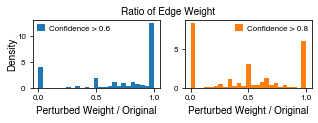

In [89]:
plt.figure(figsize=(5,1.25), )
plt.suptitle("Ratio of Edge Weight", fontsize=10, y=1.025)
for i, (thresh, color) in enumerate(zip(["0.6", "0.8"], plt.rcParams["axes.prop_cycle"].by_key()["color"])):
    plt.subplot(1,2,i+1)
    plt.hist(u_master_edge_df[f"weight_{thresh}"] / u_master_edge_df["weight_0.0"],
             bins=np.linspace(0,1,26), density=True,
             color=color,
             label=f"Confidence > {thresh}")
    plt.xlabel("Perturbed Weight / Original", fontsize=10)
    if i == 0: plt.ylabel("Density", fontsize=10, labelpad=-0.5)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(frameon=False,
               handlelength=1, handleheight=1, handletextpad=0.5,
               borderaxespad=0.1,
               fontsize=8)
    
for ext in ["png", "pdf"]:
    print("Saving", ext)
    plt.savefig(os.path.join(figure_dir, "Supplement", f"threshold_edge_ratios.{ext}"), bbox_inches="tight")

Saving png
Saving pdf


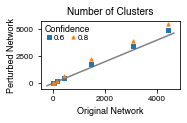

In [85]:
plt.figure(figsize=(2.5, 1.25))
xs = np.array([master_node_df[chi].max() for chi in reneel_params])
ys = np.array([[master_node_df[f"{chi}_{thresh}"].max() for chi in reneel_params] for thresh in ["0.6", "0.8"]])
plt.scatter(xs, ys[0], label="0.6",
            marker="s", s=10,)
#             c=[float(c) for c in reneel_params], cmap=ListedColormap(cc.kr))
plt.scatter(xs, ys[1], label="0.8",
            marker="^", s=10,)
#             c=[float(c) for c in reneel_params], cmap=ListedColormap(cc.kr))
plt.plot(plt.gca().get_xlim(), plt.gca().get_xlim(), color="gray", zorder=0)
plt.legend(title="Confidence", fontsize=8, title_fontsize=9,
           frameon=False,
           handlelength=1, handletextpad=0.1,
           ncol=2, columnspacing=0.5, labelspacing=0,
           borderaxespad=0.1)
plt.title("Number of Clusters", fontsize=10)
plt.xlabel("Original Network", fontsize=9)
plt.ylabel("Perturbed Network", fontsize=9, labelpad=-0.5)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
for ext in ["png", "pdf"]:
    print("Saving", ext)
    plt.savefig(os.path.join(figure_dir, "Supplement", f"cluster_counts_threshold.{ext}"), bbox_inches="tight")

# Edge swaps
Let's do a quick computation to see how many edges change from being within-cluster to cross-cluster, or vicce versa, as the confidence threshold increases. 

In [55]:
master_edge_df

,pre,post,weight_0.0,weight_0.6,weight_0.8,0.0_pre_0.0,0.05_pre_0.0,0.1_pre_0.0,0.25_pre_0.0,0.5_pre_0.0,...,0.5_pre_0.8,0.75_pre_0.8,1.0_pre_0.8,0.0_post_0.8,0.05_post_0.8,0.1_post_0.8,0.25_post_0.8,0.5_post_0.8,0.75_post_0.8,1.0_post_0.8
0,295115429,5813098375,1,1,1,4,5,6,4,11,...,439,662,825,2,2,10,34,151,184,206
871,294782432,5813098375,1,1,1,4,5,6,4,11,...,175,375,475,2,2,10,34,151,184,206
2405,294787849,5813098375,1,1,0,4,5,2,4,11,...,433,641,800,2,2,10,34,151,184,206
3058,295798962,5813098375,2,2,1,4,5,6,4,11,...,275,1204,1019,2,2,10,34,151,184,206
4367,295474250,5813098375,10,9,6,4,5,2,4,11,...,128,1164,1604,2,2,10,34,151,184,206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2836962,2026154319,2304437366,1,0,0,8,19,57,285,1075,...,1620,2902,3975,8,15,256,453,2217,3954,5487
2689507,1776161570,5813002965,1,1,0,8,19,57,285,1075,...,1620,2902,5364,8,15,24,592,2066,3659,5432
2814116,1963070366,5813002965,2,1,0,8,19,57,197,763,...,2066,3659,5460,8,15,24,592,2066,3659,5432
2809481,1961688670,5813002965,1,1,0,8,19,57,197,763,...,2066,3659,5024,8,15,24,592,2066,3659,5432


In [56]:
cs = ['0.6', '0.8']
cols = ['P_stay_within_' + c for c in cs] + ['P_stay_valid_'+c for c in cs]
summary_df = pd.DataFrame(index=reneel_params, columns=cols)
for c in cs:
    for chi in reneel_params:
        within_cluster_original = master_edge_df[chi + '_pre_0.0'] == master_edge_df[chi + '_post_0.0']
        within_cluster_thresh = master_edge_df[chi+'_pre_' + c] == master_edge_df[chi +'_post_' + c]
        still_connected = master_edge_df['weight_'+c] > 0
        summary_df.loc[chi, 'P_stay_within_'+c] = (within_cluster_original & within_cluster_thresh).sum() / within_cluster_original.sum()
        summary_df.loc[chi, 'P_stay_valid_'+c] = (within_cluster_original & within_cluster_thresh & still_connected).sum() / (within_cluster_original & still_connected).sum()

summary_df

,P_stay_within_0.6,P_stay_within_0.8,P_stay_valid_0.6,P_stay_valid_0.8
0.0,0.993734,0.990982,0.994186,0.992336
0.05,0.983119,0.984653,0.984398,0.986013
0.1,0.988723,0.982006,0.989482,0.984232
0.25,0.960803,0.93355,0.96314,0.940833
0.5,0.833528,0.747554,0.848667,0.782502
0.75,0.909443,0.852314,0.914034,0.863453
1.0,0.905627,0.810183,0.911127,0.820689


In [161]:
chi, thresh = "0.05", "0.6"

j = joint_marginal(master_node_df, chi, f"{chi}_{thresh}", True)
    
oc = master_node_df.value_counts(chi)
oc.name = "n_neurons"
oc = pd.DataFrame(oc)
# oc = oc[oc.n_neurons >= min_original_size]
oc = oc.sort_values("n_neurons", ascending=False)
oc[f"{chi}_new"] = range(1, oc.shape[0]+1)
j = j.merge(oc[f"{chi}_new"], left_on=chi, right_index=True)

top_map = j.sort_values(f"{chi}_{thresh}_fraction", ascending=False).groupby(f"{chi}_{thresh}").agg({f"{chi}_new": "first"})
top_map = top_map.sort_values(f"{chi}_new")
top_map[f"{chi}_{thresh}_new"] = range(1,top_map.shape[0]+1)
j = j.merge(top_map[f"{chi}_{thresh}_new"], left_on=f"{chi}_{thresh}", right_index=True)

display(j)

print("First original cluster below size threshold:", oc[oc.n_neurons < min_original_size][f"{chi}_new"].min())
# print("First confidence cluster below size threshold:", )

,0.05,0.05_0.6,joint_count,0.05_count,0.05_0.6_count,joint_fraction,0.05_fraction,0.05_0.6_fraction,0.05_new,0.05_0.6_new
0,1,1,3455,4345,3526,0.158975,0.795167,0.979864,1,1
19,8,1,19,3310,3526,0.000874,0.005740,0.005389,2,1
17,3,1,30,2895,3526,0.001380,0.010363,0.008508,3,1
34,5,1,6,2713,3526,0.000276,0.002212,0.001702,4,1
49,16,1,3,712,3526,0.000138,0.004213,0.000851,7,1
...,...,...,...,...,...,...,...,...,...,...
95,53,69,1,1,1,0.000046,1.000000,1.000000,50,60
96,36,65,1,1,1,0.000046,1.000000,1.000000,43,57
102,56,34,1,1,1,0.000046,1.000000,1.000000,55,63
103,42,66,1,1,1,0.000046,1.000000,1.000000,41,56


First original cluster below size threshold: 23


In [90]:
# chi, thresh = "0.0", "0.6"
min_original_size = 5

fs = []
for chi in reneel_params[:3]:
    chi_fs = []
    for thresh in ["0.6", "0.8"]:
        j = joint_marginal(master_node_df, chi, f"{chi}_{thresh}", True)
    
        oc = master_node_df.value_counts(chi)
        oc.name = "n_neurons"
        oc = pd.DataFrame(oc)
        # oc = oc[oc.n_neurons >= min_original_size]
        oc = oc.sort_values("n_neurons", ascending=False)
        oc[f"{chi}_new"] = range(1, oc.shape[0]+1)
        j = j.merge(oc[f"{chi}_new"], left_on=chi, right_index=True)

        top_map = j.sort_values(f"{chi}_{thresh}_fraction", ascending=False).groupby(f"{chi}_{thresh}").agg({f"{chi}_new": "first"})
        top_map = top_map.sort_values(f"{chi}_new")
        top_map[f"{chi}_{thresh}_new"] = range(1,top_map.shape[0]+1)
        j = j.merge(top_map[f"{chi}_{thresh}_new"], left_on=f"{chi}_{thresh}", right_index=True)
        
        fig_kws = dict(title=None,
                       border_fill_color=None,
                       outline_line_color=None,
                       background_fill_color=None,)
        if thresh == "0.8":
            fig_kws["x_range"] = x_range=chi_fs[0].x_range
        f = figure(**fig_kws)
        cmap = LinearColorMapper(palette=cc.bkr[::-1], low=0, high=1)
        f.rect(x=f"{chi}_new", y=f"{chi}_{thresh}_new",
               width=f"{chi}_fraction", height=f"{chi}_{thresh}_fraction",
#                width=1, height=1,
#                alpha=f"{chi}_fraction",
#                color=linear_cmap(f"{chi}_fraction", cc.bkr, low=0, high=1),
#                color = transform(f"{chi}_fraction", cmap),
               source=j[j[f"{chi}_count"] >= min_original_size])
#         j[(j[f"{chi}_count"] >= min_original_size) & (j[f"{chi}_{thresh}_count"] >= min_original_size)]
        
#         if float(chi) > 0:
#             original_cutoff = oc[oc.n_neurons < min_original_size][f"{chi}_new"].min()
#             f.add_layout(Span(location=original_cutoff - 0.5, dimension="height",
#                               line_color="gray", line_dash="dashed"))
        
        f.xaxis.ticker = FixedTicker(ticks=np.arange(1, j[chi].max() + 1))
        f.yaxis.ticker = FixedTicker(ticks=np.arange(1, j[f"{chi}_{thresh}"].max() + 1))
        f.axis.major_label_text_font_size = "0pt"
        f.axis.major_tick_line_width = 1
        
        f.add_tools(HoverTool(name=thresh,
                              tooltips={"Original Cluster":"@{"+chi+"}",
                                        "Threshold Cluster": "@{"+f"{chi}_{thresh}"+"}",
                                        "Count / Original": "@{joint_count} / @{"+f"{chi}_count"+"} (@{"+f"{chi}_fraction"+"}{4.2%})",
                                        "Count / New": "@{joint_count} / @{"+f"{chi}_{thresh}_count"+"} (@{"+f"{chi}_{thresh}_fraction"+"}{4.2%})"},
                              toggleable=True))
#         if thresh == "0.8":
#             cb = ColorBar(color_mapper=cmap,
#                           border_line_color=None,
#                           location=(0,0))
#             f.add_layout(cb,"right")
#         show(f)
#         if float(chi) >= 0.1:
        f.grid.visible = False
        chi_fs.append(f)
    
    fs.append(chi_fs)

# cb_fig = figure()
# cb = ColorBar(color_mapper=cmap,
#               border_line_color=None,
#               location=(0,0),
#               major_tick_in=0)
# cb_fig.add_layout(cb,"right")
# show(cb_fig)

g = gridplot(fs, plot_width=300, plot_height=600)
show(g)



In [94]:
(master_edge_df["weight_0.6"] / master_edge_df["weight_0.0"]).mean()

0.7319928719620501

# The Fan-Shaped Body
Let's start by finding FB in the thresholded networks

In [36]:
original_FB = master_node_df[master_node_df['0.0'] == 2]
# original_FB[['0.0', '0.0_0.6', '0.0_0.8']].
for chi in reneel_params:
    print("Chi =", chi)
    display(original_FB.value_counts([chi, chi+'_0.6', chi+'_0.8']))

Chi = 0.0


0.0  0.0_0.6  0.0_0.8
2    5        5          2383
     1        1             2
     5        3             2
     3        3             1
     5        1             1
              2             1
     6        5             1
dtype: int64

Chi = 0.05


0.05  0.05_0.6  0.05_0.8
2     9         8           2311
5     2         2             52
10    5         8              6
5     9         8              5
      2         8              3
10    9         8              3
3     3         3              2
10    5         5              2
2     2         8              1
      5         5              1
      7         7              1
      9         2              1
5     2         3              1
16    7         7              1
      9         8              1
dtype: int64

Chi = 0.1


0.1  0.1_0.6  0.1_0.8
7    11       14         1295
2    10       10          462
21   12       12          253
28   18       30          175
              34          167
7    11       10            5
28   18       14            4
7    11       3             3
              12            3
8    3        3             3
6    2        2             2
7    10       10            2
     12       12            2
15   5        5             2
34   9        14            1
              9             1
28   18       148           1
34   11       14            1
7    120      149           1
21   12       14            1
8    11       14            1
2    10       12            1
7    9        9             1
6    10       10            1
2    10       147           1
              45            1
53   15       47            1
dtype: int64

Chi = 0.25


0.25  0.25_0.6  0.25_0.8
30    41        40          706
5     36        35          389
71    118       114         187
94    55        103         170
102   165       159         158
                           ... 
30    36        40            1
                35            1
      32        29            1
24    96        94            1
325   297       519           1
Length: 102, dtype: int64

Chi = 0.5


0.5   0.5_0.6  0.5_0.8
12    169      172        231
219   202      180        171
70    194      207        164
               157        164
425   646      688        155
                         ... 
123   151      134          1
      156      156          1
124   222      184          1
169   151      193          1
1146  462      470          1
Length: 323, dtype: int64

Chi = 0.75


0.75  0.75_0.6  0.75_0.8
685   297       232         129
165   257       194         110
323   285       287          80
782   349       298          77
9     212       156          67
                           ... 
848   289       1074          1
                307           1
                232           1
837   532       269           1
2691  2839      3238          1
Length: 635, dtype: int64

Chi = 1.0


1.0   1.0_0.6  1.0_0.8
929   441      262        57
1417  426      367        42
74    259      185        40
1048  1476     1465       39
18    322      240        37
                          ..
1530  425      879         1
      1013     882         1
      3903     4139        1
1544  248      177         1
4382  3086     3247        1
Length: 1055, dtype: int64

In [39]:
switched_00 = original_FB[(original_FB['0.0_0.6'] != 5) | (original_FB['0.0_0.8'] != 5)]
switched_00

,0.0,0.05,0.1,0.25,0.5,0.75,1.0,0.0_0.6,0.05_0.6,0.1_0.6,...,0.5_0.6,0.75_0.6,1.0_0.6,0.0_0.8,0.05_0.8,0.1_0.8,0.25_0.8,0.5_0.8,0.75_0.8,1.0_0.8
294792344,2,5,2,4,4,81,87,5,2,10,...,149,269,310,3,3,10,34,128,203,274
357901388,2,5,2,4,4,59,112,5,2,10,...,149,281,388,2,2,10,34,128,184,799
577369038,2,3,8,104,446,1010,1377,3,3,3,...,44,61,63,3,3,3,259,1014,1775,2349
941123943,2,2,21,71,219,685,929,6,9,12,...,369,297,377,5,8,12,114,361,232,285
1298476253,2,10,21,47,329,748,1002,1,5,12,...,458,796,3082,1,8,12,124,467,2912,253
1325799453,2,10,21,47,329,748,3319,1,5,12,...,458,796,3773,1,5,12,124,467,2930,4005
1602549038,2,10,21,130,329,748,3611,5,5,12,...,458,2663,3777,1,8,12,124,467,2933,4008
5813064478,2,5,2,4,4,81,1283,5,2,10,...,149,269,967,3,2,10,34,128,203,824


In [40]:
get_cluster_representatives?

In [41]:
color_by = '0.0'
original_FB_reps = get_cluster_representatives('0.0', n=200, cluster_threshold=1, df=original_FB)

ipv.figure()
ipv.show()
for i, (body, cluster) in enumerate(zip(original_FB_reps.index, original_FB_reps[color_by])):
    s = get_skeleton(body)
    skel_lines = s[s.link != -1][['rowId', 'link']].values - 1
    ipv.plot_trisurf(s['x'], -s['z'], s['y'], lines=skel_lines, color=palette[cluster % len(palette)])
for i, body in enumerate(switched_00.index):
    s = get_skeleton(body)
    skel_lines = s[s.link != -1][['rowId', 'link']].values - 1
    ipv.plot_trisurf(s['x'], -s['z'], s['y'], lines=skel_lines, color='red')

# def simple_ipv_plots(df, chis=reneel_params, figure={}, view={}):
#     """Generate an ipyvolume figure per parameter in `chis` showing the skeletons
#     of all neurons in `df` colored by that value of chi."""
#     for color_by in chis:
#         ipv.figure(**figure)
#         ipv.show()
#         ipv.style.box_off()
#         ipv.style.axes_off()
#         for i, (body, cluster) in enumerate(zip(df.index, df[color_by])):
#             s = get_skeleton(body)
#             skel_lines = s[s.link != -1][['rowId', 'link']].values - 1
#             ipv.plot_trisurf(s['x'], -s['z'], s['y'], lines=skel_lines, color=palette[cluster % len(palette)])
#         ipv.view(**view)

2021 12 15 10:08:51  Found previous selection using these criteria.
2021 12 15 10:08:51  To refresh, delete the file figures/paper/bodyids/selected_cells_v1.1_0.0_200_1_default.txt
2021 12 15 10:08:51  Selected 200 / 2391 (8.36%) of the given dataframe


# Load the threshdolded networks

In [19]:
threshold_06 = pd.read_excel("hemibrain/confidence_threshold/06confidence.xlsx", skiprows=1).rename(columns={'chi=0':'0.0', 1:'1.0'})
threshold_06.set_index('ID', inplace=True)
threshold_06.rename(columns={c: str(c) + '_0.6' for c in threshold_06.columns}, inplace=True)


threshold_08 = pd.read_excel("hemibrain/confidence_threshold/08confidence.xlsx", skiprows=1).rename(columns={'chi=0':'0.0', 1:'1.0'})
threshold_08.set_index('ID', inplace=True)
threshold_08.rename(columns={c: str(c) + '_0.8' for c in threshold_08.columns}, inplace=True)

In [ ]:
# threshold_06.rename(columns={c: str(c) + '_0.6' for c in threshold_06.columns}, inplace=True)

In [ ]:
# threshold_08.rename(columns={c: str(c) + '_0.8' for c in threshold_06.columns}, inplace=True)

In [20]:
HB_node_df = HB_node_df.merge(threshold_06, left_index=True, right_index=True)
HB_node_df = HB_node_df.merge(threshold_08, left_index=True, right_index=True)
HB_node_df

,0.0,0.05,0.1,0.25,0.5,0.75,1.0,instance,celltype,pre,...,0.5_0.6,0.75_0.6,1.0_0.6,0.0_0.8,0.05_0.8,0.1_0.8,0.25_0.8,0.5_0.8,0.75_0.8,1.0_0.8
200326126,1,1,1,1,1,1,1,CL141_L,CL141,395,...,1,1,1,1,1,1,1,1,1,1
202916528,2,2,2,2,2,2,2,FS4C(FQ12)_C4_R,FS4C,95,...,148,209,236,5,8,10,33,127,154,170
203253072,2,2,2,3,3,3,3,FS4A(AB)(FQ12)_C3_R,FS4A,62,...,164,232,263,5,8,10,39,145,173,189
203253253,2,3,2,4,4,4,4,SMP505(PDM22)_L,SMP505,415,...,149,210,237,5,3,10,34,128,155,171
203257652,2,2,2,2,2,5,2,FS4C(FQ12)_C6_R,FS4C,65,...,150,211,238,5,8,10,33,137,229,259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7112579848,4,5,6,18,36,47,598,SLP169_R,SLP169,88,...,479,838,1073,2,2,2,4,489,239,1910
7112579856,1,1,1,140,1058,2306,3266,LC20,LC20,319,...,1359,2754,3899,1,1,1,27,1668,3149,4299
7112615127,6,8,14,44,226,3070,3127,AVLP335_R,AVLP335,362,...,1156,2774,3632,4,4,4,7,1431,3414,4666
7112617294,6,8,14,44,226,2028,3381,AVLP331_R,AVLP331,285,...,892,2594,3684,4,4,4,7,1416,2526,3908


In [39]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score
# normalized_mutual_info_score(HB_node_df['0.0'], HB_node_df['0.0_0.6'])

In [22]:
normalized_mutual_info_score(HB_node_df['0.0'], HB_node_df['0.0_0.8'])

0.9626433363245459

In [37]:
# print(f"{'chi':>4s}|{'c>0.6':>8s}|{'c>0.8':>8s}")
# print("-" * 22)
c06 = [normalized_mutual_info_score(HB_node_df[chi], HB_node_df[chi + '_0.6']) for chi in reneel_params]
c08 = [normalized_mutual_info_score(HB_node_df[chi], HB_node_df[chi + '_0.8']) for chi in reneel_params]
cpair = [normalized_mutual_info_score(HB_node_df[chi+'_0.6'], HB_node_df[chi+'_0.8']) for chi in reneel_params]
# for chi in reneel_params:
#     nmi_06 = normalized_mutual_info_score(HB_node_df[chi], HB_node_df[chi + '_0.6'])
#     nmi_08 = normalized_mutual_info_score(HB_node_df[chi], HB_node_df[chi + '_0.8'])
#     print(f"{chi:4s}|{nmi_06:8.4f}|{nmi_08:8.4f}")
df = pd.DataFrame({"chi":reneel_params, "original_vs_0.6":c06, "original_vs_0.8":c08, "0.6_vs_0.8":cpair})
df

,chi,original_vs_0.6,original_vs_0.8,0.6_vs_0.8
0,0.0,0.968002,0.962643,0.959780
1,0.05,0.937049,0.950529,0.936236
2,0.1,0.962623,0.947802,0.966080
3,0.25,0.943119,0.915591,0.930154
4,0.5,0.919082,0.886335,0.920875
5,0.75,0.945952,0.921575,0.936038
6,1.0,0.945419,0.924768,0.940359


In [40]:
# print(f"{'chi':>4s}|{'c>0.6':>8s}|{'c>0.8':>8s}")
# print("-" * 22)
ami_c06 = [adjusted_mutual_info_score(HB_node_df[chi], HB_node_df[chi + '_0.6']) for chi in reneel_params]
ami_c08 = [adjusted_mutual_info_score(HB_node_df[chi], HB_node_df[chi + '_0.8']) for chi in reneel_params]
cpair = [adjusted_mutual_info_score(HB_node_df[chi+'_0.6'], HB_node_df[chi+'_0.8']) for chi in reneel_params]
# for chi in reneel_params:
#     nmi_06 = adjusted_mutual_info_score(HB_node_df[chi], HB_node_df[chi + '_0.6'])
#     nmi_08 = adjusted_mutual_info_score(HB_node_df[chi], HB_node_df[chi + '_0.8'])
#     print(f"{chi:4s}|{nmi_06:8.4f}|{nmi_08:8.4f}")
df = pd.DataFrame({"chi":reneel_params, "original_vs_0.6":ami_c06, "original_vs_0.8":ami_c08, "0.6_vs_0.8":cpair})
df

,chi,original_vs_0.6,original_vs_0.8,0.6_vs_0.8
0,0.0,0.967983,0.962621,0.959755
1,0.05,0.936496,0.950125,0.935703
2,0.1,0.961536,0.946133,0.964955
3,0.25,0.935061,0.902556,0.918631
4,0.5,0.860064,0.792657,0.848433
5,0.75,0.854944,0.781691,0.816550
6,1.0,0.807498,0.723966,0.772872
